# E10: 뉴스기사 요약해보기

## Step 1. 데이터 수집하기

- NLTK는 Natural Language Toolkit의 축약어로 영어 기호, 통계, 자연어 처리를 위한 라이브러리
 - NLTK의 불용어(stopwords)를 사용
 - 이 NLTK에는 I, my, me, over, 조사, 접미사와 같이 문장에는 자주 등장
 - 의미를 분석하고 요약하는 데는 거의 의미가 없는 100여개의 불용어가 미리 정리되어 있다 
 - 이를 이용해 다운로드한 리뷰 파일에서 불용어를 제거하는 작업을 진행할 예정

In [77]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import  time

# 뉴스 기사 데이터 불러오기
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

# 전체 샘플수가 98401개이다.
print('전체 샘플수 :', (len(data)))

# 간단히 10만 개의 샘플만 사용해보자
data.sample(10)

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


전체 샘플수 : 98401


,headlines,text
39376,Pranab Mukherjee's daughter rubbishes reports ...,Former President Pranab Mukherjee's daughter a...
47283,Moving clam served to diner at Japanese sushi ...,A customer at a Japanese eatery ate a sushi di...
2433,Rohit Sharma 1st Indian to slam 5 ODI hundreds...,Opener Rohit Sharma has become the first India...
1222,K'taka Cong MLA injured in fight with another ...,Karnataka Congress MLA Anand Singh was hospita...
89903,"Supreme Court to adjudicate in Leander, Rhea P...",The Supreme Court has decided to intervene in ...
83315,"Oracle, Getty support $1.2 billion fine agains...",Seven US companies including Oracle and Getty ...
60607,Auto driver molests 21-year-old girl in Bengaluru,A 21-year-old student was allegedly molested b...
34997,TDP MLA out on bail slaps man over torn poster...,TDP MLA Chinthamaneni Prabhakar allegedly slap...
49562,What a guy: Anushka on Kohli's ODI century in ...,Actress Anushka Sharma shared a series of pict...
63127,Rohit Sharma sets record for most sixes by an ...,Indian opener Rohit Sharma slammed four sixes ...


- 이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있다.
- text를 요약한 것이 headlines이다.
- 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있다.
- 추출적 요약을 하는 경우에는 오직 text열만을 사용한다

## Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 
만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

이제 데이터를 불러왔으니 전처리를 진행해 볼게요.
빈칸으로 존재하는 null 데이터, 의미는 같지만 다른 식으로 작성된 글 같은 중복 항목과 같은 
학습할 때 방해가 되는 데이터를 먼저 솎아낼 거예요.

### 중복 샘플과 NULL 값이 존재하는 샘플 제거
- 데이터의 중복 샘플 유무를 확인해보자

In [2]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


- 전체 샘플수가 98401였던것과 비교해보면 중복된 data가 text의 경우 41개의 샘플, headlines의 경우 121개의 샘플이 줄었다는 것을 확인할 수 있다
- text 자체가 중복된 경우, 데이터프레임의 drop_duplicates()를 사용해서 중복 샘플을 제거하자. 

In [3]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


- drop_duplicates()가 중복된 Null들을 지워주기는 하겠지만, 여전히 Null 값 한 개가 어딘가 남아있을 수 있다.
- .isnull().sum()을 사용해서 데이터프레임에 Null 값이 있는지 확인해보자

In [4]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- 확인해보니 null 값이 남아있지 않았다. 

### 텍스트 정규화와 불용어 제거
- 남은  단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있다.
-  이런 경우 기계가 굳이 이들을 마치 다른 단어로 간주하게 해서 연산량을 늘리는 것보다는 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있는 방법이다.
- 이러한 방법론을 텍스트 처리에서는 텍스트 정규화(text normalization) 라고 한다.
- 여기서는 텍스트 정규화를 위한 사전(dictionary)을 아래와 같이 구성한다.
##### 불용어란?
- 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들

In [5]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

정규화 사전의 수:  120
불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', '

In [6]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # NLTK를 이용해 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    # Abstractive한 문장 요약 결과문이 자연스러우려면 
    # 상대적으로 문장 길이가 짧은 summary 전처리를 할 때 불용어를 제거하지 않는게 좋다
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

- LTK에서 미리 정의하여 제공하고 있는 불용어는 총 179개, 179개의 불용어 제거
- 모든 영어 문자는 소문자로 만들고, 섞여있는 html 태그를 제거
- 정규 표현식을 통해 각종 특수문자를 제거

In [7]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print(clean_text[:5])

# 시간 측정
start = time.time()  # 시작 시간 저장
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illne

- 훈련 데이터 전체에 대해서 전처리를 수행해보자
- 이때, text는 불용어를 제거, headlines의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출한다.

In [8]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

print(clean_summary[:5])

# 시간 측정
start = time.time()  # 시작 시간 저장
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']
time : 4.7206878662109375e-05


### 멀티프로세싱 사용
- 싱글 프로세스로 실행하면 데이터 전처리 하는데 많은 시간이 걸리는 것을 확인했다.
- 이를  해결하기 위해 멀티프로세싱을 활용하여 별도의 프로세스를 생성하여 병렬처리하면 CPU수에 비례하여 획기적으로 소요 시간을 줄일 수 있다.

In [9]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_summary = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
# Summary에 대해서 전처리 함수를 호출해 줄 때, 
# 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 Falses넣습니다
print(clean_summary)

180.7837188243866  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak 

- 시간을 보면 멀티프로세싱을 거치자 대략 700초에서 180초로 시간이 단축되었음을 확인할 수 있다.
- 텍스트 정제의 과정을 거친 후에는 다시 한번 빈(empty) 샘플이 생겼는지 확인해봐야 한다.
- 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있기 때문이다.
- 그렇게 되면 샘플 자체가 빈 값을 가지게 된다.
- 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장한 후 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체한다.

In [11]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

# .isnull().sum()을 사용해서 Null 값이 생겼는지 확인해본다
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 훈련데이터와 테스트데이터 나누기
-  진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시해 줘야 한다. 
#### 샘플의 최대 길이 정하기
- Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 본다. 시각화된 정보를 바탕으로 훈련에 사용할 샘플의 최대 길이를 정하도록 한다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


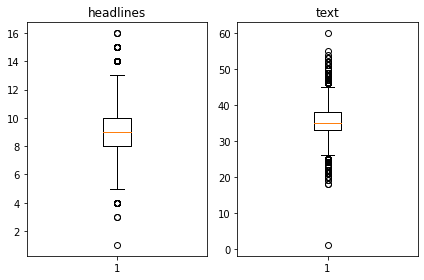

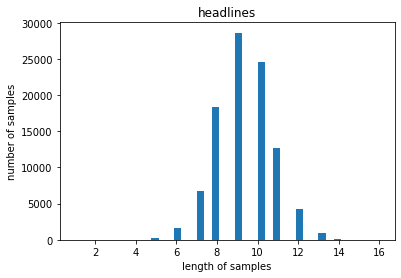

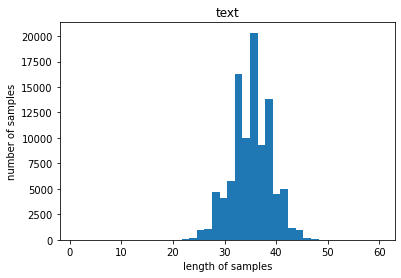

In [13]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 요약된 정보인 headline의 경우, 최소 길이 : 1, 최대 길이 : 16, 평균 길이 : 9.299532330215534
- text 정보인 text의 경우, 최소 길이 : 1, 최대 길이 : 60, 평균 길이 : 35.09968483123221
- 요약된 정보의 길이가 평균적으로도 text 정보의 0.26배라는 것을 확인할 수 있었고, 최대 길이 역시 대략 0.26배라는 것을 그래프와 수치로 확인하였다.
- 최대길이를 정확하게 확인해서 곧이 곧대로 설정할 수도 있겠지만, 최대 길이와 최소 길이를 적당히 잘라주면 100퍼센트는 아니지만 충분히 높은 확률로 필요한 데이터를 사용할 수 있다. 너무 동떨어진 샘플을 제외시키는 것이 더 유의미할 수 있기 때문이다.

In [19]:
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [20]:
# 최대 길이를 정확하게 설정해주면
text_max_len =60
summary_max_len = 16

below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


In [26]:
# 최대 길이를 임의로 지정해보면
text_max_len =50
summary_max_len = 15

below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9999694997966653


- text의 최대 길이를 60에서 50으로, headlines의 최소 길이를 16에서 15로 설정해줘도 정확도가 99퍼센트 이상인 것을 확인하였다.

In [28]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98343


중복을 제외한 전체 샘플수가 98360였는데 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제한 결과 전체 샘플의 수가 17개 줄은 것을 확인할 수 있다.
### 시작 토큰과 종료 토큰 추가하기
- 디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈춘다.
##### seq2seq 훈련
- 시작 토큰과 종료 토큰을 추가하는 이유: seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있다.
- 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 이름을 부여해서 앞, 뒤로 추가한다.
- decoder_input: 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름
- decoder_target: 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름
- 두 개의 문장 모두 headlines 열로부터 만든다.

In [43]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [47]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

# 훈련 데이터와 테스트 데이터를 분리
#  encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만든다
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

# 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주어서 잘 섞인 샘플을 만든다
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
# 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

# 이렇게 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분한다.
#:표시의 위치에 주의
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

[27592 42813 23386 ... 46914 42071 78891]
테스트 데이터의 수 : 19668
훈련 데이터의 개수 : 78675
훈련 레이블의 개수 : 78675
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


- 훈련 데이터의 수는 78675, 테스트 데이터의 수는 19668개인 것을 확인했다.
### 정수 인코딩
#### 단어 집합(vocabulary) 만들기 및 정수 인코딩
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어야 한다.이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요하다. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현한다. 훈련 데이터(encoder_input_train)에 대해서 단어 집합을 만들어본다.
- Keras의 토크나이저: 입력된 훈련 데이터로부터 단어 집합을 만들 수 있도록 한다.

In [54]:
src_tokenizer = Tokenizer() # 토크나이저 정의, 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
# 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여


#이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 
#빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 한다
# 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인한다
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
#현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있다
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
# src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있다
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69597
등장 빈도가 6번 이하인 희귀 단어의 수: 47463
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22134
단어 집합에서 희귀 단어의 비율: 68.1969050390103
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4946572432787737


#### 통계 정보들을 해석해볼까요?
등장 빈도가 threshold 값인 7회 미만, 즉, 6회 이하인 단어들은 단어 집합에서 무려 68% 이상을 차지한다. 
하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.49%밖에 되지 않는다.
그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 한다.
위에서 이를 제외한 단어 집합의 크기를 8천여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 8,000으로 제한한다.
토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다.
##### 단어 집합의 크기 8000

In [56]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

#texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다. 
#현재 단어 집합의 크기를 8,000으로 제한했으니까 이제 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다.
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[447, 362, 3, 13, 1654, 380, 1860, 278, 11, 42, 240, 9, 156, 3220, 192, 1570, 993, 5880, 4072, 286, 468, 156, 176, 101, 84, 2211, 1338, 1084, 11, 6252], [406, 127, 985, 7559, 147, 1, 84, 32, 147, 3551, 6455, 124, 514, 147, 243, 527, 4323, 41, 994, 2405, 819, 4371, 147, 99, 1, 127, 1487, 4794, 627, 410], [68, 79, 535, 672, 273, 446, 1879, 2978, 2758, 178, 452, 910, 1675, 1, 3379, 535, 46, 5409, 4234, 4324, 663, 4, 263, 269, 235, 23, 399, 2139, 6123, 6708, 3823]]


더 이상 텍스트 데이터가 아니라 정수가 나오고 있다.
Summary 데이터에 대해서도 동일한 작업을 수행한다.
케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산한다.

- 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

In [57]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30139
등장 빈도가 5번 이하인 희귀 단어의 수: 19702
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10437
단어 집합에서 희귀 단어의 비율: 65.37045024718803
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.649343116141016


- 등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 65%를 차지하고 있다.
- 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 4.69%밖에 되지 않는다.
- 2,000을 단어 집합의 크기로 제한
##### 단어 집합의 크기 2000

In [58]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 562, 38, 26, 4, 6, 18, 146, 148], [1, 50, 1092, 7, 288, 195], [1, 422, 423, 7, 226, 1225, 250], [1, 45, 364, 3, 48, 930, 88, 23], [1, 359, 17, 1854, 15, 646, 660]]
target
decoder  [[562, 38, 26, 4, 6, 18, 146, 148, 2], [50, 1092, 7, 288, 195, 2], [422, 423, 7, 226, 1225, 250, 2], [45, 364, 3, 48, 930, 88, 23, 2], [359, 17, 1854, 15, 646, 660, 2]]


- 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있다.
- 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 요약문(Summary)의 경우에는 이 현상이 문제가 될 수 있다.
- 해결방안: 약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않기 때문에 길이가 0이 된 샘플들의 실제 길이는 1로 나온다. 따라서 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장한 후 이 샘플들은 모두 삭제한다.

In [60]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78663
훈련 레이블의 개수 : 78663
테스트 데이터의 개수 : 19665
테스트 레이블의 개수 : 19665


- 예상과 달리 삭제할 데이터가 없었다. 
### 패딩하기
텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해야 한다.
그렇다면 어느 길이로 패딩을 해줄까? 최대 길이로 패딩을 해보자. 어떻게? 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰준다

In [61]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

# 모델 설계하기
- 임베딩 벡터의 차원: 128로 정의, hidden state의 크기: 256으로 정의.
- hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터, LSTM의 용량의 크기나 뉴런의 개수
- 인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였다
- 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보낸다
## Seq2seq

In [65]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from attention import AttentionLayer

#urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
# LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어준다

# 디코더의 출력층
# headlines의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 푼다
# 그 방법으로 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) .

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 50, 128)      1024000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_11 (LSTM)                  [(None, 50, 256), (N 394240      embedding_5[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 
실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.
## 어텐션 메커니즘
- 디코더의 출력층을 바꿔줘서 성능을 높여주도록 한다

In [66]:
# 깃허브에 공개돼 있는 어텐션 함수를 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

# 디코더의 출력층을 수정해보겠다
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층 수정
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 50, 128)      1024000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_11 (LSTM)                  [(None, 50, 256), (N 394240      embedding_5[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

- 위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용
- 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있다

# 모델 훈련하기

In [67]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 250s 776ms/step - loss: 3.4582 - val_loss: 2.8774
Epoch 2/50
308/308 [==============================] - 235s 764ms/step - loss: 2.7960 - val_loss: 2.6327
Epoch 3/50
308/308 [==============================] - 236s 767ms/step - loss: 2.5682 - val_loss: 2.4716
Epoch 4/50
308/308 [==============================] - 236s 766ms/step - loss: 2.3928 - val_loss: 2.3480
Epoch 5/50
308/308 [==============================] - 236s 767ms/step - loss: 2.2733 - val_loss: 2.2601
Epoch 6/50
308/308 [==============================] - 236s 765ms/step - loss: 2.1729 - val_loss: 2.1965
Epoch 7/50
308/308 [==============================] - 234s 759ms/step - loss: 2.0945 - val_loss: 2.1507
Epoch 8/50
308/308 [==============================] - 236s 767ms/step - loss: 2.0300 - val_loss: 2.1020
Epoch 9/50
308/308 [==============================] - 234s 761ms/step - loss: 1.9640 - val_loss: 2.0683
Epoch 10/50
308/308 [==============================] - 234s 759m

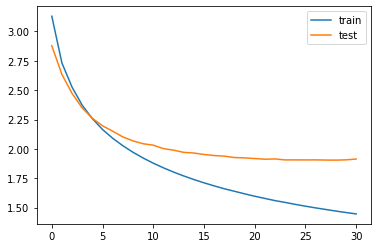

In [69]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.
## 인퍼런스 모델 구현하기
- 인퍼런스 모델 구현하는 이유?
- seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르기 때문이다.
- 훈련 단계 특징 : 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있다 > 인코더와 디코더를 엮은 통짜 모델 하나만 준비
- 인퍼런스 단계 : 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 한다 > 이때는 인코더 모델과 디코더 모델을 분리해서 설계

In [70]:
# 테스트 단계에서는 정수 인덱스 행렬로 존재하던 데이터를 실제 데이터로 복원해야하므로
# 필요한 3개의 사전을 아래와 같이 미리 준비해 둔다
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 메커니즘을 구현해주는 출력층 설계
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들자
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 모델 테스트하기
- 테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 좋다
- 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어보자
- 함수를 만들 때 제외해야 할 것
 - Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을
 - Summary의 정수 시퀀스에서는 숫자 0
 - 시작 토큰의 인덱스
 - 종료 토큰의 인덱스

In [71]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교

In [72]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : american teenager received full us colleges applied including harvard stanford brown said major political sciences pursue possible second degree economics chosen college yet added see hard work paying paying paying 
실제 요약 : us teen gets to all he to 
예측 요약 :  year old us boy to replace


원문 : adani group billion coal project australia board approved final investment decision chairman gautam adani called historic day indian investment australia notably adani invested billion project faced opposition australia largest coal project increase carbon pollution 
실제 요약 : gives final to aus project 
예측 요약 :  to billion in sports cricket


원문 : indian pacer bhuvneshwar kumar playing india picked three wickets south africa returning competitive cricket following injury wednesday bhuvneshwar back injury third odi india england gave away runs nine overs match 
실제 요약 : for india on return from injury 
예측 요약 :  india to tour india in


원문 : actor comedian kevin issued apology pregnant wife child

긍정적인 측면에서는, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들이 보인다
일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 한다는 점이 신기하다.

아쉬운 측면에서는, 좋지 않은 요약의 예도 꽤 있다는 점이다.
성능을 어떻게 개선해볼지 다양한 방법을 알아보는 것도 의미가 있을것이다.

## Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높다.
다시 말해서 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮다.
Summa의 summarize를 사용하여 추출적 요약을 해보자
### 데이터 다운로드하기

In [73]:
import requests
from summa.summarizer import summarize

# 매트릭스 시놉시스를 다운로드
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

# text에는 매트릭스 시놉시스가 문자열로 저장되어 있다. 
# 출력 결과가 아주 길기 때문에 일부만 출력해보고, 잘 저장이 되었는지 확인
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

### summarize 사용하기
Summa의 summarize()의 인자로 사용되는 값들
- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.
 - 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행하기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다. 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여본다. 원문의 0.005%만을 출력하도록 설정했어요.

In [76]:
print('Summary:')
print(summarize(text, ratio=0.005))

# 리스트로 출력 결과를 받고 싶다면 split 인자의 값을 True로 하면 된다
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

# 단어의 수로 요약문의 크기를 조절, 일단 단어를 50개만 선택
print('Summary:')
print(summarize(text, words=50))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.
Summary:
['Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.', 'Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.']
Summary:
Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


회고: 확실히 자원을 적게 투입해서 그런지 성능이 생각보다 좋지 않았다. Naver의 요약봇은 그래도 요약한 말이 말이 되고 괜찮았는데 역시 컴퓨팅 파워가 많은 기업에서 좋은 성능을 구현할 수 있는 것 같다. 내가 중고등학교를 다닐 때만 해도 구글 번역기를 돌리면 말이 안되고 문맥이 자연스럽게 이어지지 않았는데 요즘 구글 번역기를 보면 꽤 자연스럽게 번역이 되는 것 같다. 외국 여행을 해도 번역기가 있으면 따로 통역사나 가이드 없이도 여행을 할 수 있는 환경이 마련된 것 같다.